In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import re
from joblib import Parallel, delayed
from tqdm import tqdm

In [2]:
def assign_hhblits_hit(hit_name):
    if '~' in hit_name:
        return 'defense'
    elif 'PF' in hit_name:
        return 'pfam'
    else:
        return 'innate'

In [3]:
def parse_fasta_to_dataframe(file_path):
    seq_id = []
    seq = []
    current_seq = ''
    with open(os.path.expanduser(file_path), 'r') as file:
        for line in file:
            if line.startswith('>'):
                if current_seq:
                    seq.append(current_seq)
                seq_id.append(line.strip().lstrip('>'))
                current_seq = ''
            else:
                current_seq += line.strip()
        if current_seq:
            seq.append(current_seq)
    return pd.DataFrame({'seq_id': seq_id, 'seq': seq})

In [4]:
select_prefilt_seqs = pd.read_table('../data/interim/prefilt_pd_seq_acc.txt')
select_protein_operons = pd.read_csv('../data/interim/prefilt_pd_prediction_df.csv')
hhblits_df = pd.read_csv('../data/interim/pd_prefilt_pfam_innate_df_domains.csv')
select_protein_seq_df = parse_fasta_to_dataframe('../data/interim/ecor_pd_seqs_prefilt.faa')
candidate_defense_proteins = pd.read_csv('../data/interim/easy_filt_novel_def_proteins.csv')

In [5]:
hhblits_df['hit_category'] = hhblits_df['hit_name'].apply(assign_hhblits_hit)
hhblits_df['q_ali_len'] = hhblits_df['qend'] - hhblits_df['qstart']

In [6]:
select_protein_seq_df['seq_len'] = select_protein_seq_df['seq'].str.len()
select_protein_seq_df['query'] = select_protein_seq_df['seq_id'].str.split('.', expand=True)[0]


## Filter putative defense sequences
We'll filter putative defense sequences that have >50% coverage with known defense genes.


In [7]:
prob_cutoff = 50
cov_cutoff = 0.5

In [8]:
hhblits_defense_df = (hhblits_df[(hhblits_df['Prob'] > prob_cutoff) &
                                 (hhblits_df['hit_category'] == 'defense')]
                      .sort_values('q_ali_len', ascending=False)
                      .groupby('query')
                      .head(1)
                      .reset_index(drop=True)
                      .merge(select_protein_seq_df, how='inner', on='query'))
hhblits_defense_df['qcov'] = hhblits_defense_df['q_ali_len']/hhblits_defense_df['seq_len']

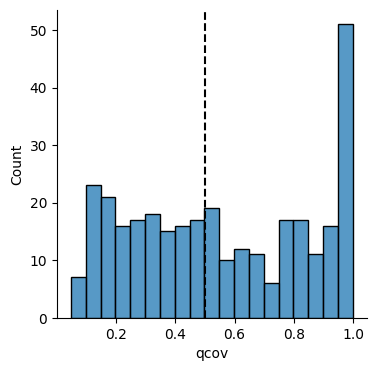

In [9]:
plt.subplots(figsize=(4,4))
sns.histplot(data=hhblits_defense_df, 
             x='qcov', binwidth=0.05)
sns.despine()
plt.axvline(x=cov_cutoff, linestyle='dashed', color='black')

In [10]:
blacklisted_prefilt_accs = hhblits_defense_df.loc[(hhblits_defense_df['qcov'] > 0.5), 
                                                  'query'].to_list()
len(blacklisted_prefilt_accs)

169

In [14]:
candidate_defense_proteins['accession_stub'] = candidate_defense_proteins['product_accession'].str.split('.', expand=True)[0]

In [22]:
candidate_defense_proteins.loc[candidate_defense_proteins['product_accession'].isin(select_prefilt_seqs['product_accession']) & 
                               ~candidate_defense_proteins['accession_stub'].isin(blacklisted_prefilt_accs), 'cluster_id'].nunique()

459

## Sensitively cluster prefilt seqs

In [13]:
msa_dir = '../data/interim/pd_prefilt_msas/'
passing_a3ms = []
for a3m in os.listdir(msa_dir):
    if '.a3m' in a3m:
        query = a3m.split('.')[0]
        if query not in blacklisted_prefilt_accs:
            passing_a3ms.append(a3m)
len(passing_a3ms)

469

In [14]:
msa_filt_dir_1 = '../data/interim/pd_filt_1_msas/'
if 'pd_filt_1_msas' in os.listdir('../data/interim'):
    os.system('rm -r ' + msa_filt_dir_1)
os.mkdir(msa_filt_dir_1)
for a3m in passing_a3ms:
    os.system('cp ' + msa_dir + a3m  + ' ' + msa_filt_dir_1 + a3m)

In [15]:
pd_filt_1_db_folder = '../data/interim/pd_filt_1_db/'
if 'pd_filt_1_db' in os.listdir('../data/interim'):
    os.system('rm -r ' + pd_filt_1_db_folder)  
os.mkdir(pd_filt_1_db_folder)
pd_filt_1_db_stub = pd_filt_1_db_folder + 'pd_filt_1_db'

os.system(' '.join(['~/hhsuite/bin/ffindex_build', 
                    '-s', 
                    pd_filt_1_db_stub + '_a3m.ffdata', 
                    pd_filt_1_db_stub + '_a3m.ffindex',
                    msa_filt_dir_1]))

0

Due to the inability to run module from jupyter run the following in a separate terminal

    module load mpi/openmpi-4.1.4

    export SLURM_TASKS_PER_NODE=48

    mpirun -np 48 ffindex_apply_mpi ../data/interim/pd_filt_1_db/pd_filt_1_db_a3m.ff{data,index} \\
    -i ../data/interim/pd_filt_1_db/pd_filt_1_db_hhm.ffindex -d ../data/interim/pd_filt_1_db/pd_filt_1_db_hhm.ffdata \\
    -- hhmake -i stdin -o stdout -v 1
    
    mpirun -np 48 cstranslate_mpi -f -x 0.3 -c 4 -I a3m -i ../data/interim/pd_filt_1_db/pd_filt_1_db_a3m -o ../data/interim/pd_filt_1_db/pd_filt_1_db_cs219
    
    sort -k3 -n -r ../data/interim/pd_filt_1_db/pd_filt_1_db_cs219.ffindex | cut -f1 > ../data/interim/pd_filt_1_db/sorting.dat
    
    ffindex_order ../data/interim/pd_filt_1_db/sorting.dat ../data/interim/pd_filt_1_db/pd_filt_1_db_hhm.ff{data,index} ../data/interim/pd_filt_1_db/pd_filt_1_db_hhm_ordered.ff{data,index}
    
    mv ../data/interim/pd_filt_1_db/pd_filt_1_db_hhm_ordered.ffindex ../data/interim/pd_filt_1_db/pd_filt_1_db_hhm.ffindex
    
    mv ../data/interim/pd_filt_1_db/pd_filt_1_db_hhm_ordered.ffdata ../data/interim/pd_filt_1_db/pd_filt_1_db_hhm.ffdata
    
    ffindex_order ../data/interim/pd_filt_1_db/sorting.dat ../data/interim/pd_filt_1_db/pd_filt_1_db_a3m.ff{data,index} ../data/interim/pd_filt_1_db/pd_filt_1_db_a3m_ordered.ff{data,index}
    
    mv ../data/interim/pd_filt_1_db/pd_filt_1_db_a3m_ordered.ffindex ../data/interim/pd_filt_1_db/pd_filt_1_db_a3m.ffindex
    
    mv ../data/interim/pd_filt_1_db/pd_filt_1_db_a3m_ordered.ffdata ../data/interim/pd_filt_1_db/pd_filt_1_db_a3m.ffdata

In [23]:
filt_seq_df = select_protein_seq_df[~select_protein_seq_df['query'].isin(blacklisted_prefilt_accs)]
len(filt_seq_df)

469

In [24]:
filt_seq_df.to_csv('../data/interim/pd_filt_1_seqs.csv', index=False)